# Unsupervised graph classification/representation learning via distances

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/embeddings/gcn-unsupervised-graph-embeddings.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/embeddings/gcn-unsupervised-graph-embeddings.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

This demo demonstrated training a graph classification model without supervision. This model could be used to compute embedding vectors or representations for graphs.

The algorithm uses a ground-truth distance between graphs as a metric to train against, by embedding pairs of graphs simultaneously and combining the resulting embedding vectors to match the distance.

It is inspired by UGraphEmb[1].

[1]: Y. Bai et al., “Unsupervised Inductive Graph-Level Representation Learning via Graph-Graph Proximity,” [arXiv:1904.01098](http://arxiv.org/abs/1904.01098) [cs, stat], Jun. 2019.

In [24]:
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification

import pandas as pd
import numpy as np
import networkx as nx
import tensorflow as tf
from tensorflow import keras
import os 

from IPython.display import display, HTML

## Dataset

The PROTEINS dataset consists of about one thousand graphs, with binary labels `1` or `2`.

In [19]:
# dataset = sg.datasets.PROTEINS()
# graphs, graph_labels = dataset.load()

In [ ]:
# src = 'C:/Users/sgarcia40/ML Projects/Causal Inference/kdd2018-tutorial/TimeSeriesNetworkViz/gexf_graphs'
# dest = 'C:/Users/sgarcia40/UCSC_DBDA_Spring_2020/Project_3/UGraphEmb/data/Stellargraph/train'

# i = 0
# src_files = os.listdir(src)
# for file_name in src_files:
#     full_file_name = os.path.join(src, file_name)
#     if os.path.isfile(full_file_name):
#         shutil.copy(full_file_name, dest)
#         i = i+1
        
# print("The number of graphs copied is: ", i)

In [25]:
# Convert gexf graphs into networkx
src = 'C:/Users/sgarcia40/UCSC_DBDA_Spring_2020/Project_3/UGraphEmb/data/Stellargraph/train'

src_files = os.listdir(src)
accumulator = 0
file_cntr = 0

graphs = list()

for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    
    g = nx.read_gexf(full_file_name)
    graph = StellarGraph.from_networkx(g)
    graphs.append(graph)



In [26]:
def append_ext_to_filepath(ext, fp):  
    if ext not in fp:
        fp += ext    
    
    return fp

def load_glabels_from_txt(filepath):
    filepath = append_ext_to_filepath('.txt', filepath)
    rtn = {}
    int_map = {}
    seen_glabels = set()
    with open(filepath) as f:
        for line in f:
            ls = line.rstrip().split()
            assert (len(ls) == 2)
            gid = int(ls[0])
            try:
                glabel = int(ls[1])
            except ValueError:
                label_string = ls[1]
                glabel = int_map.get(label_string)
                if glabel is None:
                    glabel = len(int_map)  # guarantee 0-based
                    int_map[label_string] = glabel  # increase the size of int_map by 1
            rtn[gid] = glabel
            seen_glabels.add(glabel)
    if 0 not in seen_glabels:  # check 0-based graph labels
        raise RuntimeError('{} has no glabel 0; {}'.format(filepath, seen_glabels))
    return rtn

In [27]:
# load the graph labels from file and transform into an array of glabels

filepath = 'C:\\Users\\sgarcia40\\UCSC_DBDA_Spring_2020\\Project_3\\UGraphEmb\\data\\Project\\glabels.txt'
glabels_dic = load_glabels_from_txt(filepath)        

glabel_data = list(glabels_dic.items())
tmp_arr_2d = np.array(glabel_data)

_, glabels = zip(*tmp_arr_2d) 
glabels = np.asarray(glabels)

In [28]:
# convert array of glabels into a dtype category
df = pd.DataFrame(list(glabels), dtype="category")

# change glabels to graph_labels later
graph_labels = df[0]

In [29]:
graph_labels.value_counts().to_frame()

,0
0,189
1,61
5,45
2,27
3,21
4,19
7,5
6,4


The `graphs` value consists of many `StellarGraph` instances:

In [30]:
print(graphs[0].info())

StellarGraph: Undirected multigraph
 Nodes: 3, Edges: 2

 Node types:
  2: [1]
    Features: none
    Edge types: 2-default->1
  1: [1]
    Features: none
    Edge types: 1-default->0, 1-default->2
  0: [1]
    Features: none
    Edge types: 0-default->1

 Edge types:
    1-default->2: [1]
        Weights: all 1 (default)
    0-default->1: [1]
        Weights: all 1 (default)


In [35]:
graphs[0].nodes

<bound method StellarGraph.nodes of <stellargraph.core.graph.StellarGraph object at 0x00000235A53B1548>>

In [33]:
print(graphs[1].info())

StellarGraph: Undirected multigraph
 Nodes: 45, Edges: 52

 Node types:
  9: [1]
    Features: none
    Edge types: 9-default->27, 9-default->4
  8: [1]
    Features: none
    Edge types: 8-default->0, 8-default->33
  7: [1]
    Features: none
    Edge types: 7-default->12, 7-default->41
  6: [1]
    Features: none
    Edge types: 6-default->39
  5: [1]
    Features: none
    Edge types: 5-default->39
  44: [1]
    Features: none
    Edge types: 44-default->20
  43: [1]
    Features: none
    Edge types: 43-default->34, 43-default->39
  42: [1]
    Features: none
    Edge types: 42-default->20, 42-default->39
  41: [1]
    Features: none
    Edge types: 41-default->20, 41-default->7
  40: [1]
    Features: none
    Edge types: 40-default->31, 40-default->35
  4: [1]
    Features: none
    Edge types: 4-default->17, 4-default->20, 4-default->37, 4-default->9
  39: [1]
    Features: none
    Edge types: 39-default->10, 39-default->11, 39-default->12, 39-default->27, 39-default->28, ... (

Summary statistics of the sizes of the graphs:

In [31]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,276.0,276.0
mean,4.5,3.7
std,8.2,8.6
min,2.0,1.0
25%,2.0,1.0
50%,2.0,1.0
75%,3.2,2.2
max,103.0,102.0


## Create the model

In [32]:
generator = PaddedGraphGenerator(graphs)

ValueError: graphs: expected only graphs with a single node type, found a graph with node types: '0', '1', '2'

In [22]:
generator = FullBatchNodeGenerator(graphs[0], method="gcn")

RuntimeError: This StellarGraph has no numeric feature attributes for nodesNode features are required for machine learning

In [34]:
gc_model = sg.layer.GCNSupervisedGraphClassification(
    [64, 32], ["relu", "relu"], generator, pool_all_layers=True
)

TypeError: __init__() missing 1 required positional argument: 'generator'

In [10]:
inp1, out1 = gc_model.in_out_tensors()
inp2, out2 = gc_model.in_out_tensors()

vec_distance = tf.norm(out1 - out2, axis=1)

In [11]:
pair_model = keras.Model(inp1 + inp2, vec_distance)
embedding_model = keras.Model(inp1, out1)

## Train the model

The model is trained on 100 random pairs of graphs, along with the ground-truth distance between them.

### Similarity measure

This method can use any notion of distance or similarity between two graphs. In this case, we use something efficient, but not particularly accurate: the distance between the spectrum (or eigenvalues) of the [Laplacian matrix](https://en.wikipedia.org/wiki/Laplacian_matrix) of the graphs.

Other options include graph edit distance and minimum common subgraph, but these are NP-hard to compute and are too slow for this demonstration.

In [12]:
def graph_distance(graph1, graph2):
    spec1 = nx.laplacian_spectrum(graph1.to_networkx(feature_attr=None))
    spec2 = nx.laplacian_spectrum(graph2.to_networkx(feature_attr=None))
    k = min(len(spec1), len(spec2))
    return np.linalg.norm(spec1[:k] - spec2[:k])

### Training examples

In [13]:
graph_idx = np.random.RandomState(0).randint(len(graphs), size=(100, 2))

In [14]:
targets = [graph_distance(graphs[left], graphs[right]) for left, right in graph_idx]

In [15]:
train_gen = generator.flow(graph_idx, batch_size=10, targets=targets)

### Training procedure

In [16]:
pair_model.compile(keras.optimizers.Adam(1e-2), loss="mse")

Wall time: 1min 33s


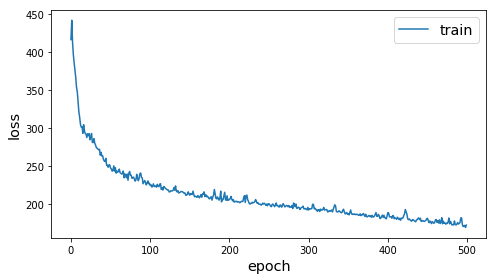

In [17]:
%%time
history = pair_model.fit(train_gen, epochs=500, verbose=2)
sg.utils.plot_history(history)

## Compute embeddings

In [18]:
embeddings = embedding_model.predict(generator.flow(graphs))

## Downstream tasks

Now that we've computed some embedding vectors in an unsupervised fashion, we can use them for other supervised, semi-supervised and unsupervised tasks.

### Supervised graph classification

We can use the embedding vectors to perform logistic regression classification, using the labels.

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

In [20]:
train_labels, test_labels = model_selection.train_test_split(
    graph_labels, train_size=0.1, test_size=None, stratify=graph_labels
)

test_embeddings = embeddings[test_labels.index - 1]
train_embeddings = embeddings[train_labels.index - 1]

lr = LogisticRegression(multi_class="auto", solver="lbfgs")
lr.fit(train_embeddings, train_labels)

y_pred = lr.predict(test_embeddings)
gcn_acc = (y_pred == test_labels).mean()
print(f"Test classification accuracy: {gcn_acc}")

Test classification accuracy: 0.655688622754491


C:\Users\sgarcia40\AppData\Local\Continuum\anaconda37\envs\tf_gpu_1dot14\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Confusion matrix

In [21]:
pd.crosstab(test_labels, y_pred, rownames=["true"], colnames=["predicted"])

predicted,1,2
true,,
1,468,129
2,216,189


### Visualising embeddings

We can also get a qualitative measure of the embeddings, using dimensionality reduction.

In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(2)
two_d = tsne.fit_transform(embeddings)

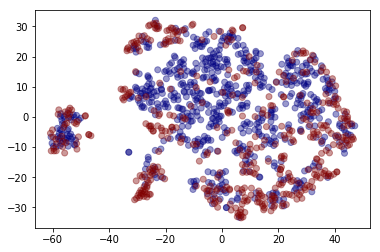

In [23]:
from matplotlib import pyplot as plt

plt.scatter(two_d[:, 0], two_d[:, 1], c=graph_labels.cat.codes, cmap="jet", alpha=0.4)

## Conclusion

This demo demonstrated training a graph classification model without supervision. This model could be used to compute embedding vectors or representations for graphs. 

The algorithm works with three components:

- a ground truth distance or similarity between two graphs such as graph edit distance, or, in this case, laplacian spectrum distance (for efficiency)
- a model that encodes graphs into embedding vectors
- a data generator that yields pairs of graphs and the corresponding ground truth distance

This model is inspired by UGraphEmb[1].

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/embeddings/gcn-unsupervised-graph-embeddings.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/embeddings/gcn-unsupervised-graph-embeddings.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>